<a href="https://colab.research.google.com/github/skywalker0803r/Chemistry-2/blob/master/Chemistry_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings;warnings.simplefilter('ignore')

In [19]:
import os
os.listdir()

['.git',
 '.ipynb_checkpoints',
 'Chemistry-2.png',
 'Chemistry_2.html',
 'Chemistry_2.ipynb',
 'README.md',
 '操作與品管數據(20200102提供).xlsx']

# load raw data

In [20]:
df = pd.read_excel('./操作與品管數據(20200102提供).xlsx')
df.head()

,Unnamed: 0,R141入口,Unnamed: 2,Unnamed: 3,Unnamed: 4,R141反應溫度,Unnamed: 6,Unnamed: 7,Unnamed: 8,R141出口,Unnamed: 10,品管數據,Unnamed: 12,Unnamed: 13
0,NaN,新鮮苯流量(M3/h),DIPB流量(M3/h),溫度(℃),壓力(KGf/cm2 G),第一床(℃),第二床(℃),第三床(℃),第四床(℃),溫度(℃),壓力(KGf/cm2 G),ppm,%,%
1,DATE,PHL-DCS-FIC1147_PV,PHL-DCS-FIC1149A_PV,PHL-DCS-TIC1163_PV,PHL-DCS-PI1162_PV,PHL-DCS-TI1166_PV,PHL-DCS-TI1167_PV,PHL-DCS-TI1168_PV,PHL-DCS-TI1169_PV,PHL-DCS-TI1170_PV,PHL-DCS-PIC1166_PV,T121 EB含量,DIPB轉化率(檢測),DIPB轉化率(計算)
2,2013-08-20 10:10:00,31.212,24.9928,169.894,[-11059] No Good Data For Calculation,167.057,166.569,166.279,165.041,[-11059] No Good Data For Calculation,12.297,NaN,NaN,58.7768
3,2013-08-20 10:20:00,31.2236,25.0668,169.753,[-11059] No Good Data For Calculation,167.051,166.576,166.26,164.97,[-11059] No Good Data For Calculation,12.2914,NaN,NaN,58.8524
4,2013-08-20 10:30:00,31.5726,25.163,169.526,[-11059] No Good Data For Calculation,167.042,166.584,166.235,164.877,[-11059] No Good Data For Calculation,12.3175,NaN,NaN,59.1137


# table data

In [21]:
cols = ['Date','R141入口_新鮮苯流量','R141入口_DIPB流量','R141入口_溫度','R141入口_壓力',
        'R141反應溫度_第一床','R141反應溫度_第二床','R141反應溫度_第三床','R141反應溫度_第四床',
        'R141出口_溫度','R141出口_壓力','T121_EB含量','DIPB轉化率(檢測)','DIPB轉化率(計算)']
values = df.iloc[2:,:]
values
new_df = pd.DataFrame(values.values,columns=cols)
new_df = new_df.set_index('Date')
print(new_df.shape)
new_df.head()

(83027, 13)


,R141入口_新鮮苯流量,R141入口_DIPB流量,R141入口_溫度,R141入口_壓力,R141反應溫度_第一床,R141反應溫度_第二床,R141反應溫度_第三床,R141反應溫度_第四床,R141出口_溫度,R141出口_壓力,T121_EB含量,DIPB轉化率(檢測),DIPB轉化率(計算)
Date,,,,,,,,,,,,,
2013-08-20 10:10:00,31.212,24.9928,169.894,[-11059] No Good Data For Calculation,167.057,166.569,166.279,165.041,[-11059] No Good Data For Calculation,12.297,NaN,NaN,58.7768
2013-08-20 10:20:00,31.2236,25.0668,169.753,[-11059] No Good Data For Calculation,167.051,166.576,166.26,164.97,[-11059] No Good Data For Calculation,12.2914,NaN,NaN,58.8524
2013-08-20 10:30:00,31.5726,25.163,169.526,[-11059] No Good Data For Calculation,167.042,166.584,166.235,164.877,[-11059] No Good Data For Calculation,12.3175,NaN,NaN,59.1137
2013-08-20 10:40:00,31.8862,25.1367,169.317,[-11059] No Good Data For Calculation,167.034,166.592,166.21,164.784,[-11059] No Good Data For Calculation,12.3179,NaN,NaN,58.8904
2013-08-20 10:50:00,31.8554,25.2207,169.665,[-11059] No Good Data For Calculation,167.026,166.6,166.186,164.691,[-11059] No Good Data For Calculation,12.3155,NaN,NaN,58.7622


# col transform

In [22]:
new_df = new_df.replace('[-11059] No Good Data For Calculation',np.nan)

In [23]:
for i in new_df.columns.tolist()[1:]:
  new_df[i] = pd.to_numeric(new_df[i])
new_df.dtypes

R141入口_新鮮苯流量     float64
R141入口_DIPB流量    float64
R141入口_溫度        float64
R141入口_壓力        float64
R141反應溫度_第一床     float64
R141反應溫度_第二床     float64
R141反應溫度_第三床     float64
R141反應溫度_第四床     float64
R141出口_溫度        float64
R141出口_壓力        float64
T121_EB含量        float64
DIPB轉化率(檢測)      float64
DIPB轉化率(計算)      float64
dtype: object

In [24]:
df = new_df
del new_df

# miss value check

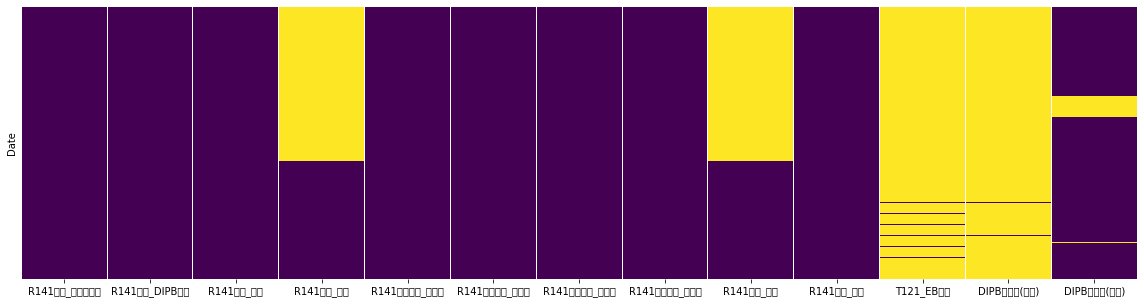

In [25]:
fig = plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [26]:
df[df['T121_EB含量'].isnull()==False][['T121_EB含量']]

,T121_EB含量
Date,
2013-08-20 16:00:00,112.0
2013-08-21 00:00:00,85.0
2013-08-21 08:00:00,109.0
2013-08-21 16:00:00,109.0
2013-08-22 00:00:00,102.0
...,...
2015-03-18 08:00:00,83.0
2015-03-18 16:00:00,84.0
2015-03-19 00:00:00,84.0


In [27]:
mt = pd.DataFrame(df.isnull().sum(),columns=['total'])
mt['%'] = (mt['total']/len(df))*100
mt

,total,%
R141入口_新鮮苯流量,71,0.085514
R141入口_DIPB流量,71,0.085514
R141入口_溫度,71,0.085514
R141入口_壓力,47276,56.940513
R141反應溫度_第一床,71,0.085514
R141反應溫度_第二床,71,0.085514
R141反應溫度_第三床,71,0.085514
R141反應溫度_第四床,71,0.085514
R141出口_溫度,47275,56.939309
R141出口_壓力,71,0.085514


# fill miss value

In [28]:
x_col = df.drop(['DIPB轉化率(檢測)','DIPB轉化率(計算)'],axis=1).columns.tolist()
x_col

['R141入口_新鮮苯流量',
 'R141入口_DIPB流量',
 'R141入口_溫度',
 'R141入口_壓力',
 'R141反應溫度_第一床',
 'R141反應溫度_第二床',
 'R141反應溫度_第三床',
 'R141反應溫度_第四床',
 'R141出口_溫度',
 'R141出口_壓力',
 'T121_EB含量']

In [29]:
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
from  tqdm import tqdm_notebook as tqdm

df = shuffle(df)
step = 10000

for i in tqdm(range(0, len(df), step)):
    start, end = i, min(i+step,len(df))
    imputer = KNNImputer(n_neighbors = 3)
    df.iloc[start:end][x_col] = imputer.fit_transform(df.iloc[start:end][x_col])

df = df.sort_index()

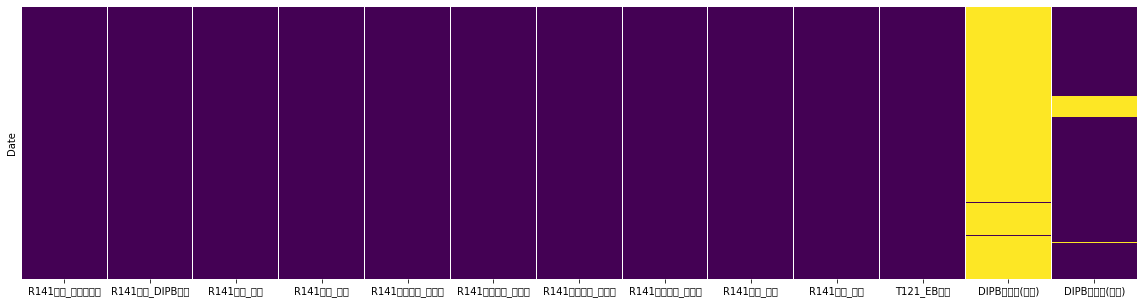

In [30]:
fig = plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# describe

In [31]:
df.describe().apply(lambda x:round(x,2))

,R141入口_新鮮苯流量,R141入口_DIPB流量,R141入口_溫度,R141入口_壓力,R141反應溫度_第一床,R141反應溫度_第二床,R141反應溫度_第三床,R141反應溫度_第四床,R141出口_溫度,R141出口_壓力,T121_EB含量,DIPB轉化率(檢測),DIPB轉化率(計算)
count,83027.00,83027.00,83027.00,83027.00,83027.00,83027.00,83027.00,83027.00,83027.00,83027.00,83027.00,488.00,76553.00
mean,33.27,22.74,165.90,14.40,157.73,157.85,157.64,156.10,158.26,11.39,98.51,60.08,58.87
std,11.02,6.74,16.81,0.17,36.04,36.12,36.08,36.57,14.51,3.14,18.82,14.73,4.01
min,0.03,0.00,110.04,7.41,17.49,17.30,17.15,0.00,54.79,0.00,8.00,-44.02,-0.63
25%,31.12,24.17,168.78,14.39,165.67,165.36,164.99,163.45,159.22,12.30,84.00,59.10,57.34
50%,35.16,24.80,170.48,14.41,167.54,167.69,167.44,166.49,162.69,12.30,96.33,64.22,58.42
75%,40.99,25.50,173.02,14.43,170.29,170.67,170.39,169.36,165.20,12.30,105.67,67.89,59.74
max,52.73,29.72,184.35,15.10,182.30,177.28,187.30,176.02,173.64,12.73,283.00,72.99,290.24


# data filter

In [32]:
def data_filter(df):
    df = df.drop('DIPB轉化率(檢測)',axis=1)
    df = df.dropna(subset=['DIPB轉化率(計算)'])
    df = df[df['DIPB轉化率(計算)']>0]
    return df

In [33]:
print(df.shape)
df = data_filter(df)
print(df.shape)

(83027, 13)
(76552, 12)


# EDA

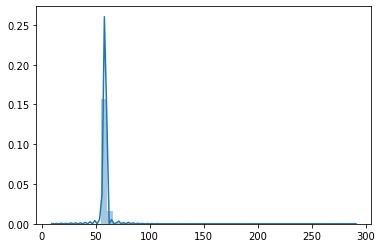

In [34]:
import seaborn as sns

sns.distplot(df['DIPB轉化率(計算)'].dropna().values)

R141入口_DIPB流量


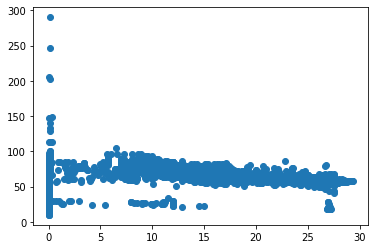

R141入口_溫度


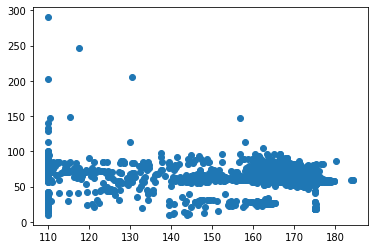

R141入口_壓力


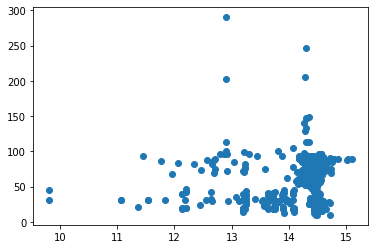

R141反應溫度_第一床


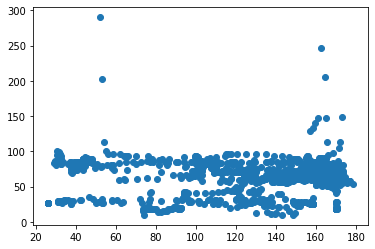

R141反應溫度_第二床


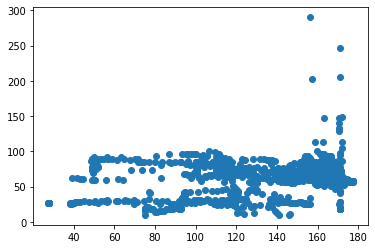

R141反應溫度_第三床


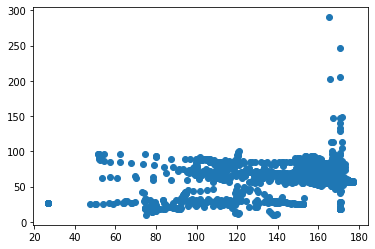

R141反應溫度_第四床


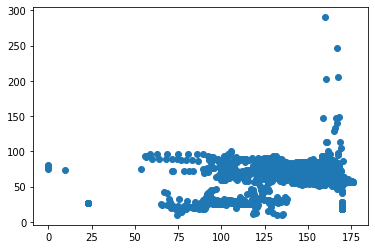

R141出口_溫度


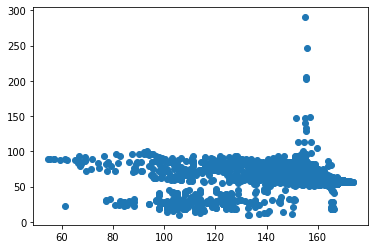

R141出口_壓力


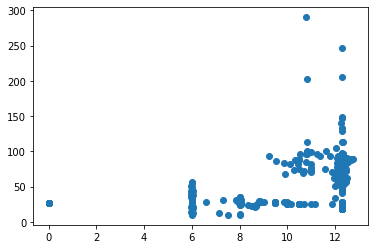

T121_EB含量


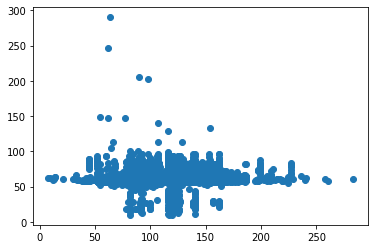

DIPB轉化率(計算)


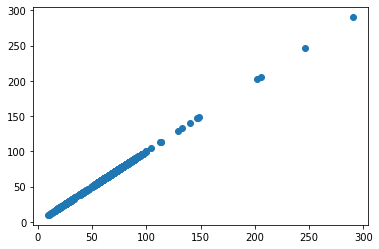

In [35]:
import matplotlib.pyplot as plt

y_name = 'DIPB轉化率(計算)'
for i in df.columns.tolist()[1:]:
  print(i)
  plt.scatter(df[i],df[y_name])
  plt.show()

In [36]:
df.corr().style.background_gradient()

,R141入口_新鮮苯流量,R141入口_DIPB流量,R141入口_溫度,R141入口_壓力,R141反應溫度_第一床,R141反應溫度_第二床,R141反應溫度_第三床,R141反應溫度_第四床,R141出口_溫度,R141出口_壓力,T121_EB含量,DIPB轉化率(計算)
R141入口_新鮮苯流量,1,0.603819,0.567095,0.127998,0.517316,0.554199,0.559799,0.597525,0.726376,0.0923441,-0.277022,-0.504919
R141入口_DIPB流量,0.603819,1,0.726661,0.288303,0.692129,0.668146,0.653712,0.678969,0.689968,0.449967,-0.157509,-0.399105
R141入口_溫度,0.567095,0.726661,1,0.369997,0.856815,0.779642,0.73683,0.690906,0.671535,0.47829,-0.00378107,-0.208163
R141入口_壓力,0.127998,0.288303,0.369997,1,0.305316,0.249331,0.301719,0.294633,0.282526,0.38137,-0.097959,0.0609584
R141反應溫度_第一床,0.517316,0.692129,0.856815,0.305316,1,0.906674,0.817723,0.744544,0.69074,0.550517,-0.0563976,-0.120226
R141反應溫度_第二床,0.554199,0.668146,0.779642,0.249331,0.906674,1,0.940852,0.855717,0.787578,0.590272,-0.0829499,-0.0633224
R141反應溫度_第三床,0.559799,0.653712,0.73683,0.301719,0.817723,0.940852,1,0.9257,0.854251,0.628129,-0.104563,-0.0412485
R141反應溫度_第四床,0.597525,0.678969,0.690906,0.294633,0.744544,0.855717,0.9257,1,0.923933,0.615091,-0.136786,-0.0902988
R141出口_溫度,0.726376,0.689968,0.671535,0.282526,0.69074,0.787578,0.854251,0.923933,1,0.440246,-0.144497,-0.238562
R141出口_壓力,0.0923441,0.449967,0.47829,0.38137,0.550517,0.590272,0.628129,0.615091,0.440246,1,-0.0648634,0.399439


# features engineering

In [37]:
pass

# feature select

In [38]:
features = df.drop(['DIPB轉化率(計算)'],axis=1).columns.tolist()
y_name = 'DIPB轉化率(計算)'

df = df[features+[y_name]].dropna(subset=[y_name])

X = df[features]
y = df[y_name]

print(X.shape,y.shape)

(76552, 11) (76552,)


# split

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

model = Pipeline(steps=[
                        ('scaler',StandardScaler()),
                        ('reg',XGBRegressor(objective='reg:squarederror')),
                        ])

# train and predict

In [41]:
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

# metric

In [42]:
FIMP = pd.DataFrame(model['reg'].feature_importances_,index=X.columns,columns=['imp'])
FIMP = FIMP.sort_values(by='imp',ascending=False)
FIMP.style.background_gradient()

,imp
R141出口_壓力,0.363323
R141入口_新鮮苯流量,0.216433
R141入口_壓力,0.0941755
T121_EB含量,0.0823782
R141入口_DIPB流量,0.0759551
R141反應溫度_第二床,0.0439353
R141反應溫度_第三床,0.0342855
R141出口_溫度,0.0288773
R141反應溫度_第一床,0.0285207
R141入口_溫度,0.0223097


In [43]:
y_pred = pd.Series(y_pred,index=y_test.index,name='y_pred')

Text(0.5, 1.0, 'Moving average 6*24(day)')

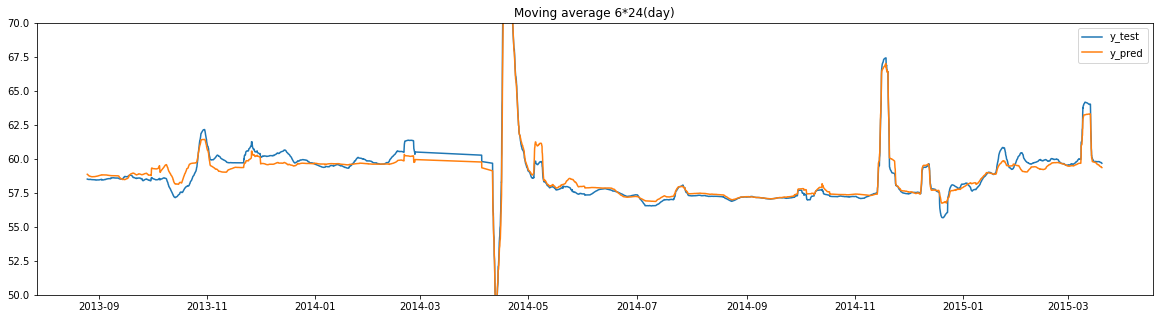

In [44]:
fig = plt.figure(figsize=(20,5))
plt.plot(y_test.sort_index().rolling(6*24).mean(),label='y_test')
plt.plot(y_pred.sort_index().rolling(6*24).mean(),label='y_pred')
plt.ylim(50,70)
plt.legend()
plt.title('Moving average 6*24(day)')

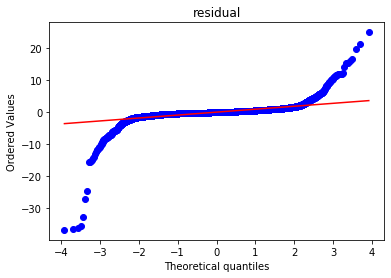

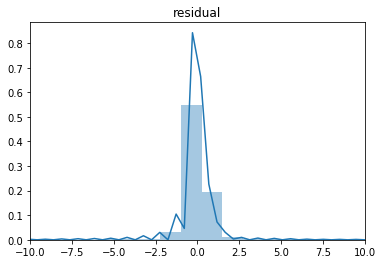

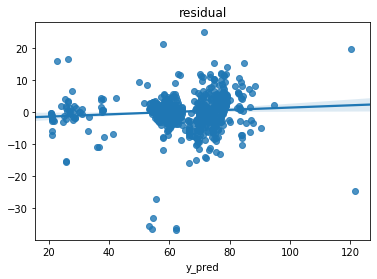

In [45]:
from scipy import stats

residual = y_test - y_pred

stats.probplot(residual, plot=plt)
plt.title('residual')
plt.show()

sns.distplot(residual)
plt.xlim(-10,10)
plt.title('residual')
plt.show()

sns.regplot(y_pred,residual)
plt.title('residual')
plt.show()

In [46]:
from sklearn.metrics import r2_score
def mape(a, b): 
  mask = a != 0
  return (np.fabs(a - b)/a)[mask].mean()

In [47]:
print('R2:',round(r2_score(y_test,y_pred),2))

R2: 0.88


In [48]:
print('mape',round(mape(y_test,y_pred)*100,2),'%')

mape 0.96 %
